In [27]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [28]:
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_decomposition import PLSRegression, CCA
import regression_common
import joblib
import matplotlib.pyplot as plt

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

In [51]:
if False: # to be done once only
    
    # Create/store/load binary image data
    if not os.path.isfile(DATA_DIR + 'binary_imgs.npy'):

        dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
        img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
        img_filenames.sort()
        print('Number of subjects: %d' % len(img_filenames))

        img_shape = load_img(img_filenames[0]).shape

        mask_img = load_mni152_brain_mask()
        masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
        masker = masker.fit()

        imgs = masker.transform(img_filenames) # break down into slices if necessary
        imgs = imgs.astype(bool)
        np.save(DATA_DIR + 'binary_imgs', imgs)

    else:
        imgs = np.load(DATA_DIR + 'binary_imgs.npy')

    imgs.shape

## Multitask analysis with 100 PC components

In [29]:
# Calculate 100 PC components
if not os.path.isfile(DATA_DIR + 'binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=100, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save(DATA_DIR + 'binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load(DATA_DIR + 'binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [30]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [62]:
## common library

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(39)

def mixup_data(X, Y, alpha=0.1, mul_factor=10):
    
    rs = np.random.RandomState(39)
    n = X.shape[0]
    
    mixed_X = np.empty((n*(mul_factor-1), X.shape[1]))
    mixed_Y = np.empty((n*(mul_factor-1), Y.shape[1]))
    
    for i in range(mul_factor-1):
        
        # sample more than needed as some will be filtered out
        lam = np.random.beta(alpha, alpha, size=round(n*1.2))
        
        # original data vectors will be concatenated later
        lam = lam[(lam!=0.0) & (lam!=1.0)][:n][:, None]
        
        shuffle_idx = rs.choice(np.arange(n), n, replace=False)

        mixed_X[i*n : (i+1)*n] = lam * X + (1 - lam) * X[shuffle_idx, :]
        mixed_Y[i*n : (i+1)*n] = lam * Y + (1 - lam) * Y[shuffle_idx, :]
        
    # concatenate original data vectors
    mixed_X = np.append(mixed_X, X, axis=0)
    mixed_Y = np.append(mixed_Y, Y, axis=0)
            
    return mixed_X, mixed_Y


SCORE_DOMAINS = ['Global Cognition', 'Language', 'Visuospatial Functioning', 'Memory',\
                 'Information Processing Speed', 'Executive Functioning']

def calculate_regression_metrics(est_cv, X_train, X_test, y_train, y_test, model_name, i_fold, score_domain=None):
    
    scores = []
    
    y_predicted_train = est_cv.predict(X_train)
    y_predicted_test = est_cv.predict(X_test)
        
    train_rsq = r2_score(y_train, y_predicted_train, multioutput='raw_values')
    test_rsq = r2_score(y_test, y_predicted_test, multioutput='raw_values')        

    train_mae = mean_absolute_error(y_train, y_predicted_train, multioutput='raw_values')
    test_mae = mean_absolute_error(y_test, y_predicted_test, multioutput='raw_values')
    
    if score_domain is None: # multioutput model
        
        for i in range(len(SCORE_DOMAINS)):
            scores.append([model_name, SCORE_DOMAINS[i], "R2", "In-sample", i_fold, train_rsq[i]])
            scores.append([model_name, SCORE_DOMAINS[i], "R2", "Out-of-sample", i_fold, test_rsq[i]])
            scores.append([model_name, SCORE_DOMAINS[i], "MAE", "In-sample", i_fold, train_mae[i]])
            scores.append([model_name, SCORE_DOMAINS[i], "MAE", "Out-of-sample", i_fold, test_mae[i]])
        
    else:

        scores.append([model_name, score_domain, "R2", "In-sample", i_fold, train_rsq])
        scores.append([model_name, score_domain, "R2", "Out-of-sample", i_fold, test_rsq])
        scores.append([model_name, score_domain, "MAE", "In-sample", i_fold, train_mae])
        scores.append([model_name, score_domain, "MAE", "Out-of-sample", i_fold, test_mae])
    
    return scores
    
    
def run_regression(X, Y, estimator, grid, model_name, random_search_cv=False, n_jobs=-1, random_iter=20, 
                   pca_fold=False, nn=False, callbacks=None, print_best_params=True, 
                   multioutput=False, mixup=False, mixup_alpha=0.1, mixup_mul_factor=10):

    scores = []
    best_params = []

    kfold_outer = KFold(n_splits=5, shuffle=True, random_state=39)

    i_fold = 1

    for train, test in kfold_outer.split(X):

        X_train = X[train]
        X_test = X[test]
        
        if pca_fold:
            pca = PCA(n_components=100)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        
        Y_train = Y[train]
        Y_test = Y[test]        
                

        if mixup:
            X_train, Y_train = mixup_data(X_train, Y_train, alpha=mixup_alpha, mul_factor=mixup_mul_factor)

        kfold_inner = KFold(n_splits=5)

        if random_search_cv:
            est_cv = RandomizedSearchCV(estimator=estimator, param_distributions=grid, n_jobs=n_jobs,
                                        cv=kfold_inner, random_state=39, n_iter=random_iter)
        else:
            est_cv = GridSearchCV(estimator=estimator, param_grid=grid, n_jobs=n_jobs,
                                  cv=kfold_inner)


        print('\n' + 'Fold-' + str(i_fold) + ':\n')
        
        if multioutput:
            
            if nn:
                est_cv.fit(X_train, Y_train, nn=True, callbacks=callbacks)

            else:
                est_cv.fit(X_train, Y_train)

            scores_fold = calculate_regression_metrics(est_cv, X_train, X_test, Y_train, Y_test, 
                                                       model_name, i_fold)

            scores.extend(scores_fold)

            best_params.append([model_name, i_fold, est_cv.best_params_])
            
            
        else: # single output models            
            
            for i_domain in range(Y.shape[1]):
                
                print(SCORE_DOMAINS[i_domain])
                
                y_train = Y_train[:, i_domain]
                y_test = Y_test[:, i_domain]
            

                if nn:
                    est_cv.fit(X_train, y_train, nn=True, callbacks=callbacks)

                else:
                    est_cv.fit(X_train, y_train)

                scores_fold = calculate_regression_metrics(est_cv, X_train, X_test, y_train, Y_test, 
                                                           model_name, i_fold, SCORE_DOMAINS[i_domain])

                scores.extend(scores_fold)

                best_params.append([model_name, SCORE_DOMAINS[i_domain], i_fold, est_cv.best_params_])
     
        
        if print_best_params:
            print(best_params[-1])

        i_fold += 1


    scores_df = pd.DataFrame(scores, columns=["Model", "Domain", "Metric", "Score type", "Fold", "Score"])    
    best_params_df = pd.DataFrame(best_params)
    
    return scores_df, best_params_df


def plot_scores(score_df, score_type, hue_order=None):

    data = score_df[(score_df["Score type"] == score_type)]
    
    palette = {"Ridge":"C0", "Multitask Ridge": "C0", "PLS": "C1", "Random Forest": "C2", "CCA": "C3", "Neural Network": "C4",
               "Neural Network (Linear)": "C5", "SVR": "C6", "XGBoost": "C7"}
    
    g = sns.catplot(x="Domain", y="Score", hue="Model", col="Metric", palette=palette,
                    data=data, ci="sd", kind="bar", hue_order=hue_order)

    g.set_axis_labels("", "Score (Mean and Standard Deviation across 5 CV folds)")

    for i, ax in enumerate(g.fig.axes):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
        ax.axhline(0, color="black")

    g.fig.suptitle("Regression results: " + score_type, y=1.08, fontsize=30)

    g.set(ylim=(-0.2, 1))

def plot_all_scores(score_df, hue_order=None):
    plot_scores(score_df, "Out-of-sample", hue_order=hue_order)
    plot_scores(score_df, "In-sample", hue_order=hue_order)

### Multitask Ridge

In [46]:
def perform_multitask_ridge(X, Y):
    estimator = MultiTaskElasticNet(l1_ratio=0.001, max_iter=10000)
    alpha = np.linspace(0, 2, 5)
    grid={"alpha": alpha}

    return run_regression(X, Y, estimator, grid, "Multitask Ridge", multioutput=True, 
                          mixup=True, mixup_alpha=0.1, mixup_mul_factor=3)

In [47]:
scores_mr, best_params_mr = perform_multitask_ridge(X_pc, Y)


Fold-1:

['Multitask Ridge', 1, {'alpha': 1.0}]

Fold-2:

['Multitask Ridge', 2, {'alpha': 1.0}]

Fold-3:

['Multitask Ridge', 3, {'alpha': 0.5}]

Fold-4:

['Multitask Ridge', 4, {'alpha': 0.5}]

Fold-5:

['Multitask Ridge', 5, {'alpha': 0.5}]


### PLS

In [48]:
def perform_pls_regr(X, Y):
    estimator = PLSRegression()
    n_components = np.linspace(1, 6, 6, dtype=int)
    grid = {'n_components': n_components}
    return run_regression(X, Y, estimator, grid, "PLS", multioutput=True, 
                          mixup=True, mixup_alpha=0.1, mixup_mul_factor=5)

In [49]:
scores_pls, best_params_pls = perform_pls_regr(X_pc, Y)


Fold-1:

['PLS', 1, {'n_components': 6}]

Fold-2:

['PLS', 2, {'n_components': 6}]

Fold-3:

['PLS', 3, {'n_components': 6}]

Fold-4:

['PLS', 4, {'n_components': 6}]

Fold-5:

['PLS', 5, {'n_components': 6}]


### CCA

In [50]:
def perform_cca_regr(X, Y):
    print('Performing CCA (5-fold nested CV)')
    estimator = CCA(n_components=6)
    n_components = np.linspace(1, 6, 6, dtype=int)
    grid = {'n_components': n_components}
    return run_regression(X, Y, estimator, grid, "CCA", multioutput=True, 
                          mixup=True, mixup_alpha=0.1, mixup_mul_factor=5)

In [51]:
scores_cca, best_params_cca = perform_cca_regr(X_pc, Y)

Performing CCA (5-fold nested CV)

Fold-1:

['CCA', 1, {'n_components': 1}]

Fold-2:

['CCA', 2, {'n_components': 1}]

Fold-3:

['CCA', 3, {'n_components': 1}]

Fold-4:

['CCA', 4, {'n_components': 1}]

Fold-5:

['CCA', 5, {'n_components': 1}]


### Random Forest Regression

In [37]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [500, 1000, 1500, 2000, 2500, 3000, 3500, 5000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [50, 100, 150, 250, 500, None]
    min_samples_split = [3, 4, 5, 6, 7, 8]
    min_samples_leaf = [1, 2, 3]
    max_samples = [0.85, 0.9, 0.95, 0.99, None]
    
    grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

    return run_regression(X, Y, estimator, grid, "Random Forest", random_search_cv=True, multioutput=True, 
                          mixup=True, mixup_alpha=0.05, mixup_mul_factor=5)

In [38]:
scores_rf2, best_params_rf2 = perform_random_forest_regr(X_pc, Y)

Performing Random Forest regression (5-fold nested CV)

Fold-1:

['Random Forest', 1, {'n_estimators': 2500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'auto', 'max_depth': 250}]

Fold-2:

['Random Forest', 2, {'n_estimators': 2500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'auto', 'max_depth': 250}]

Fold-3:

['Random Forest', 3, {'n_estimators': 2500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'auto', 'max_depth': 250}]

Fold-4:

['Random Forest', 4, {'n_estimators': 2500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'auto', 'max_depth': 250}]

Fold-5:

['Random Forest', 5, {'n_estimators': 2500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'auto', 'max_depth': 250}]


In [60]:
# Organize results from all models and plot
scores_all_models = pd.concat([scores_mr, scores_pls, scores_cca, scores_rf2], ignore_index=True)

# persist/load results
# scores_all_models.to_hdf('../data/results_pca_100_multioutput.h5', key='p', mode='w')
# scores_all_models = pd.read_hdf('../data/results_pca_100_multioutput.h5', key='p', mode='r')

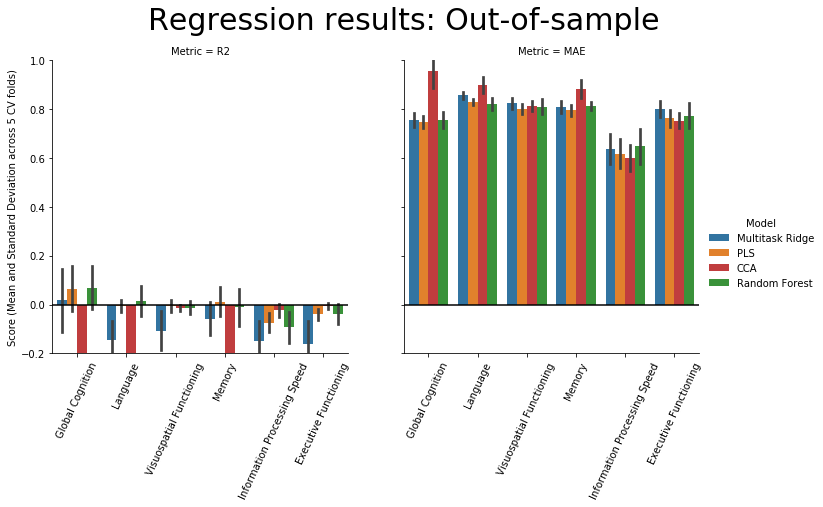

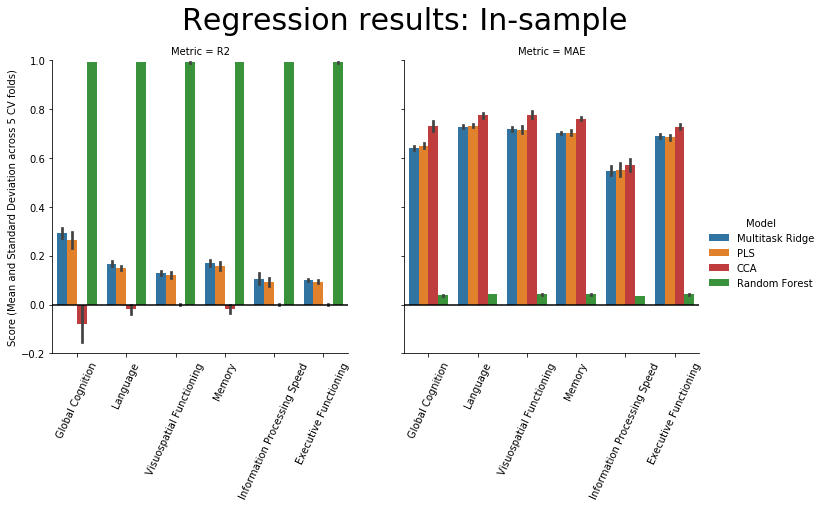

In [63]:
# Plot results
plot_all_scores(scores_all_models, hue_order=['Multitask Ridge', 'PLS', 'CCA', 'Random Forest'])